In [25]:
import numpy as np
from quadratures import get_lebedev
from tools_old import project_density, plot_density_projections, get_density_feats
from tools import interpolate_density, cartesian_to_spherical_angles, get_basis_poly, lsq_sph_coeffs, reconstructor
import qe_density_reader.reader as qer
from os.path import join as pjoin   

from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from grid.utils import generate_real_spherical_harmonics as grsh

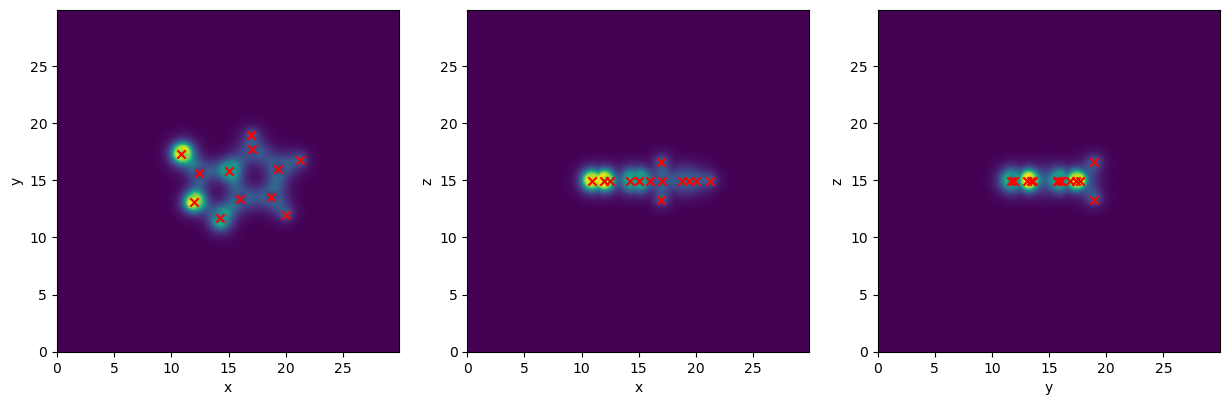

In [5]:
# Load and plot data
DIRPATH = "/home/sp2120/rds/rds-pdb_dist-PDSVOqhVGhM/data/qm9/dsgdb9nsd_atom15_out"
dens = qer.Density(pjoin(DIRPATH, "dsgdb9nsd_130767.hdf5"))

fig, ax = plot_density_projections(project_density(dens.rho), dens.atoms_positions, dens.alat)
# ax[2].set_ylim(10, 20)
# ax[2].set_xlim(10, 20)

# Least squares fitting

$$
\rho(\boldsymbol{r})=\sum_{n l m} c_{n l m} g_n(r) Y_{l m}(\theta, \phi)
$$

$$
c_{n l m}=\iiint_{\mathcal{R}^3} \mathrm{~d} V g_n(r) Y_{l m}(\theta, \phi) \rho(\boldsymbol{r})
$$


$$
Y_{l m}(\theta, \phi)= \begin{cases}\sqrt{2}(-1)^m \operatorname{Im}\left[Y_l^{|m|}(\theta, \phi)\right] & \text { if } m<0 \\ Y_l^0 & \text { if } m=0 \\ \sqrt{2}(-1)^m \operatorname{Re}\left[Y_l^m(\theta, \phi)\right] & \text { if } m>0\end{cases}
$$

$$
Y_l^m(\theta, \phi)=\sqrt{\frac{(2 l+1)}{4 \pi} \frac{(l-m) !}{(l+m) !}} P_l^m(\cos \theta) e^{i m \phi}
$$

## Our radial basis function
we use a radial basis function of polynomials:
$$

$$

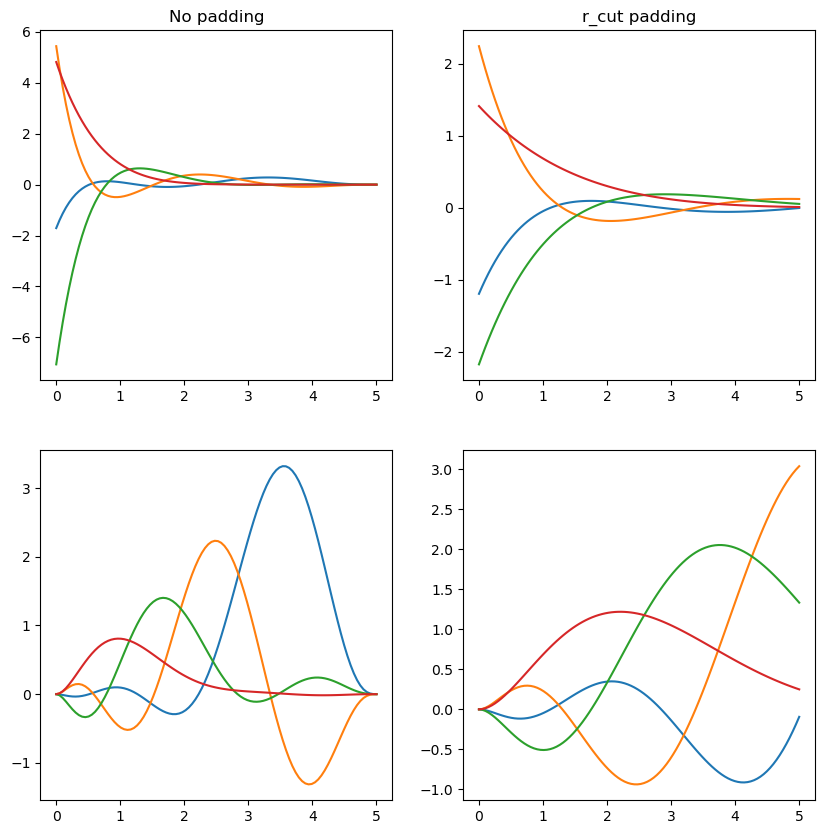

In [23]:
r_cut = 5
n_max = 4  # Number of radial basis functions
l_max = 5  # Maximum degree of spherical harmonics
rx = np.linspace(0, r_cut, 100)


rbf_no_pad = get_basis_poly(r_cut, n_max, rx, cut_pad=0)
rbf_pad = get_basis_poly(r_cut, n_max, rx, cut_pad=5)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(rx, rbf_no_pad.T, label="No pad")
ax[0, 1].plot(rx, rbf_pad.T, label="Padded")
ax[1, 0].plot(rx, rbf_no_pad.T * rx[:, None]**2, label="Scaled No pad")
ax[1, 1].plot(rx, rbf_pad.T * rx[:, None]**2, label="Scaled Padded")

ax[0, 0].set_title("No padding"); ax[0, 1].set_title("r_cut padding")
plt.show()

In [66]:
r_cut = 5
n_max = 6  # Number of radial basis functions
l_max = 8  # Maximum degree of spherical harmonics

rho, atoms_positions, coords = get_density_feats(dens)  # NOTE: this transposes the density from FORTRAN to C order
coeffs, f, masks = lsq_sph_coeffs(rho, atoms_positions, coords, r_cut, l_max, n_max)

(<Figure size 1500x1000 with 6 Axes>,
 array([<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='x', ylabel='z'>,
        <Axes: xlabel='y', ylabel='z'>], dtype=object))

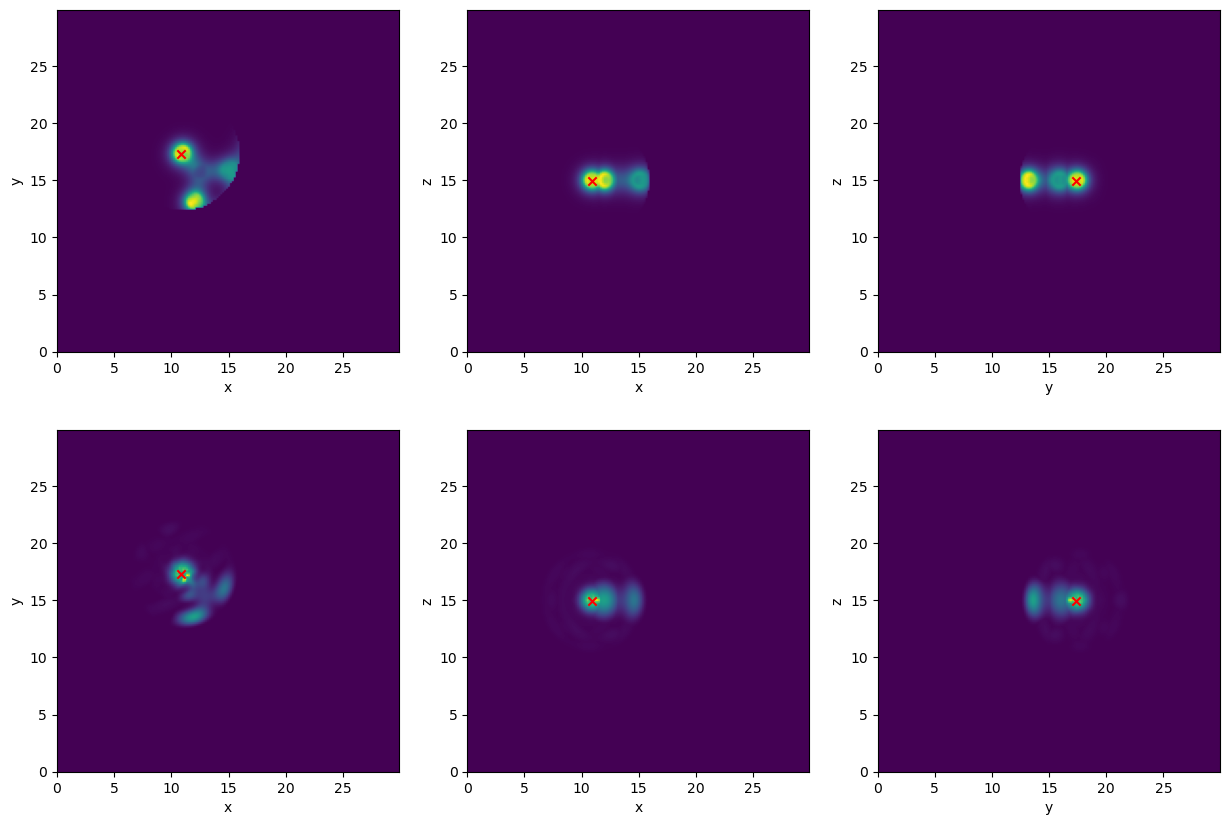

In [67]:
tst = np.zeros_like(rho)
tst[masks[0]] = f[0].T @ coeffs[0]

tst2 = np.zeros_like(rho)
tst2[masks[0]] = rho[masks[0]]


fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_density_projections(project_density(tst.T), atoms_positions[None, 0, :], dens.alat, ax=ax[1])
plot_density_projections(project_density(tst2.T), atoms_positions[None, 0, :], dens.alat, ax=ax[0])

(<Figure size 1500x1000 with 6 Axes>,
 array([<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='x', ylabel='z'>,
        <Axes: xlabel='y', ylabel='z'>], dtype=object))

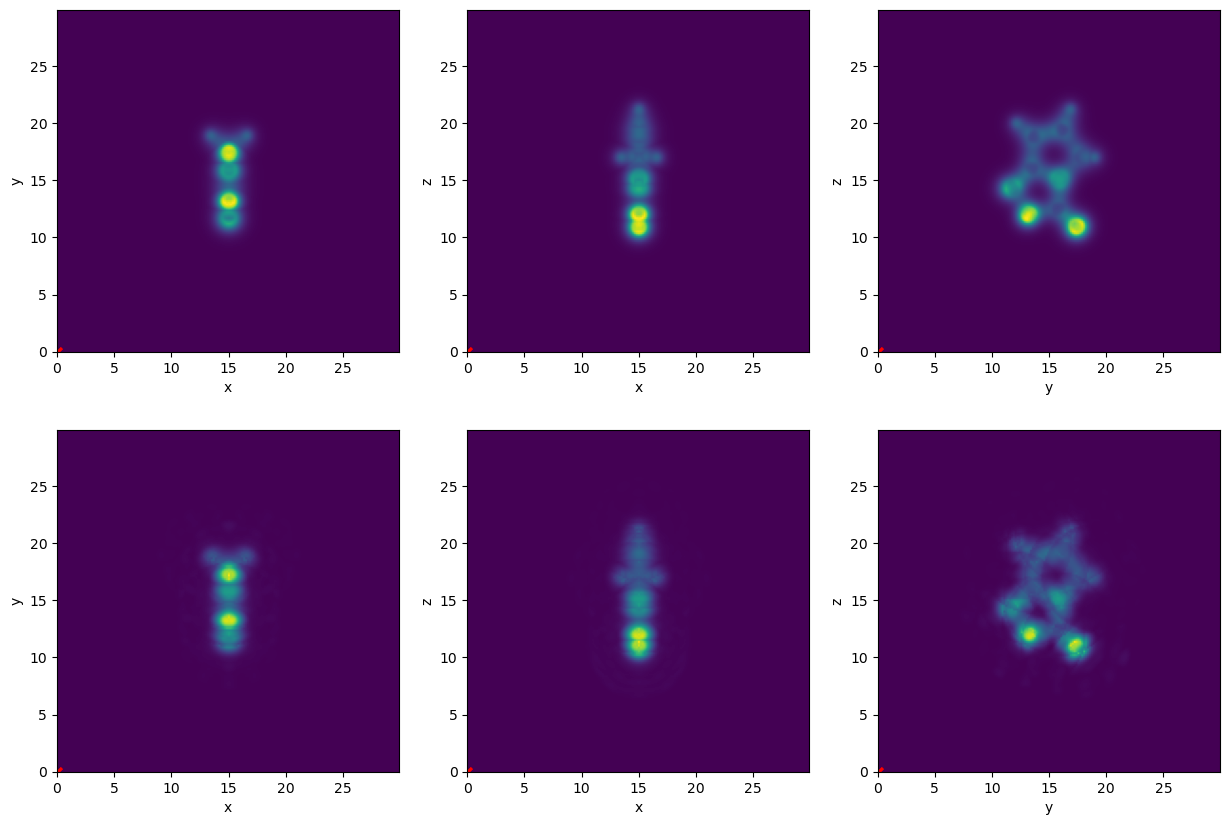

In [63]:
new_rho = reconstructor(f, masks, coeffs)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_density_projections(project_density(rho), dens.atoms_positions * 0, dens.alat, ax=ax[0])
plot_density_projections(project_density(new_rho), dens.atoms_positions * 0, dens.alat, ax=ax[1])
plt.show()

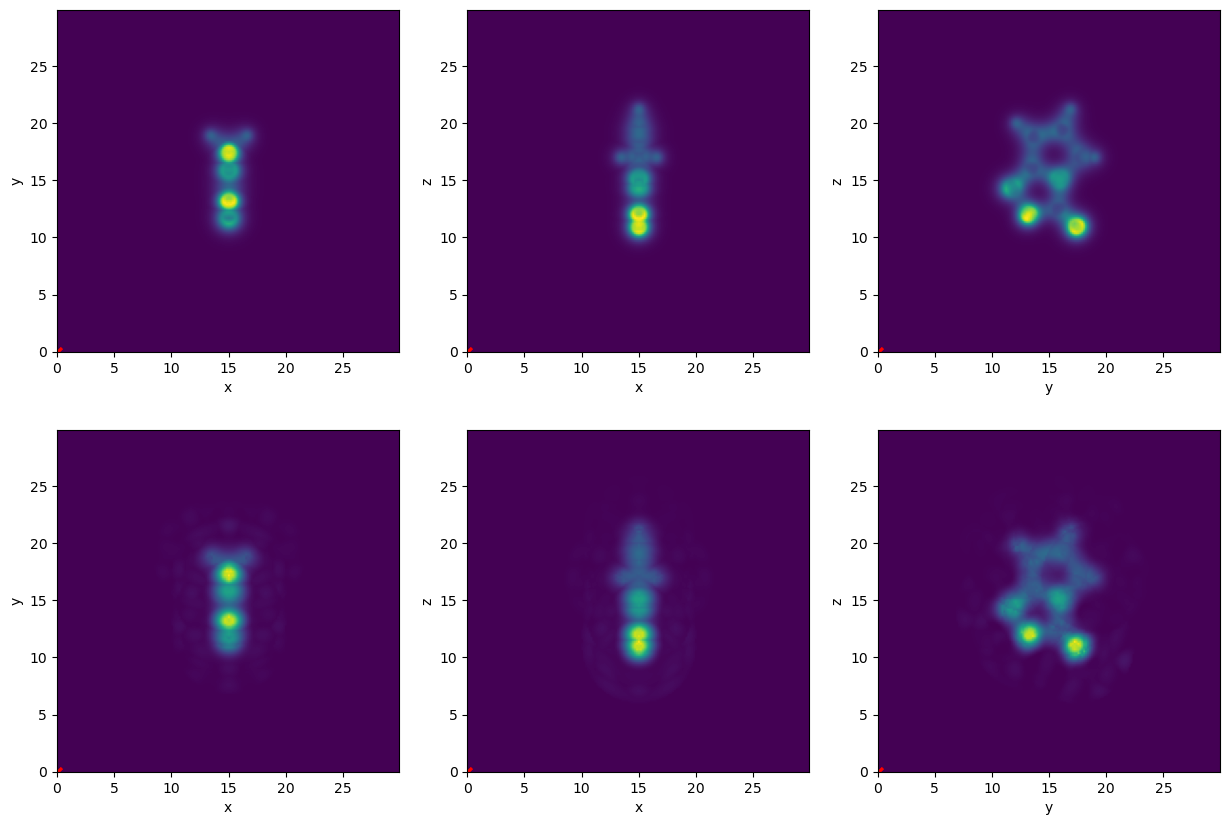

In [68]:
coeffs, f, masks = lsq_sph_coeffs(rho, atoms_positions, coords, r_cut, l_max, n_max, cut_pad=.5)
new_rho = reconstructor(f, masks, coeffs)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_density_projections(project_density(rho), dens.atoms_positions * 0, dens.alat, ax=ax[0])
plot_density_projections(project_density(new_rho), dens.atoms_positions * 0, dens.alat, ax=ax[1])
plt.show()

## Interpolation
We can test out our interpolation method. Right now we only use linear interpolation but in the future we can use something like cubic or rbf interpolation.

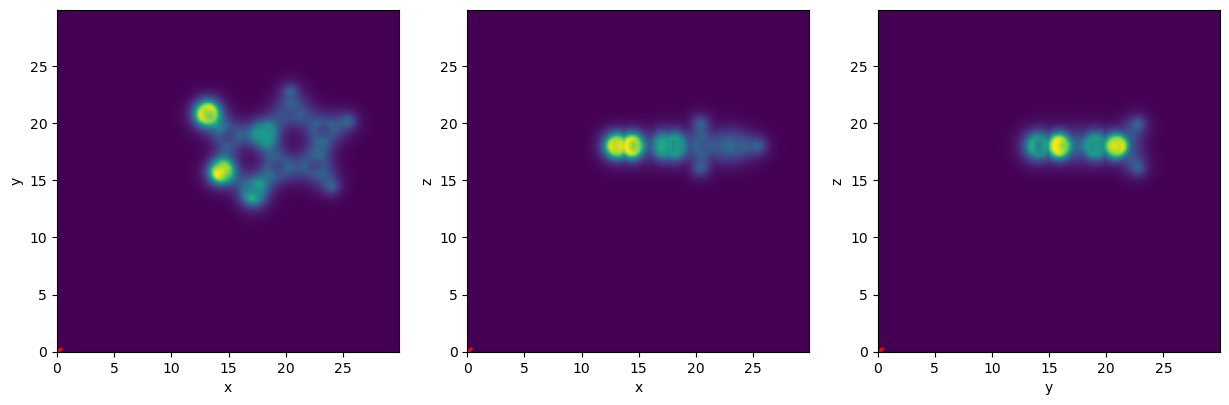

In [ ]:
# Test out interpolation
coords2 = dens.get_coords() / 1.2
rho2 = interpolate_density(dens.get_coords(), dens.rho, coords2, method="linear")
ax = plot_density_projections(project_density(rho2), dens.atoms_positions * 0, dens.alat)

In [11]:
r_cut = 5
n_max = 11
l_max = 10

ap = atoms_positions[0]

centred_coords = coords - ap
r = np.linalg.norm(centred_coords, axis=-1)
mask = r < r_cut
r = r[mask]
rho_vals = rho[mask]
theta, phi = cartesian_to_spherical_angles(*centred_coords[mask].T, r)
sh_vals = grsh(l_max, theta, phi)
poly_basis = get_basis_poly(r_cut=r_cut, n_max=n_max, rx=r)
factors = np.einsum("ik,jk->ijk", poly_basis, sh_vals).reshape(n_max * (l_max + 1) ** 2, -1)

# compute coefficients using least squares
coeffs, residuals, rank, s = lstsq(factors.T, rho_vals)

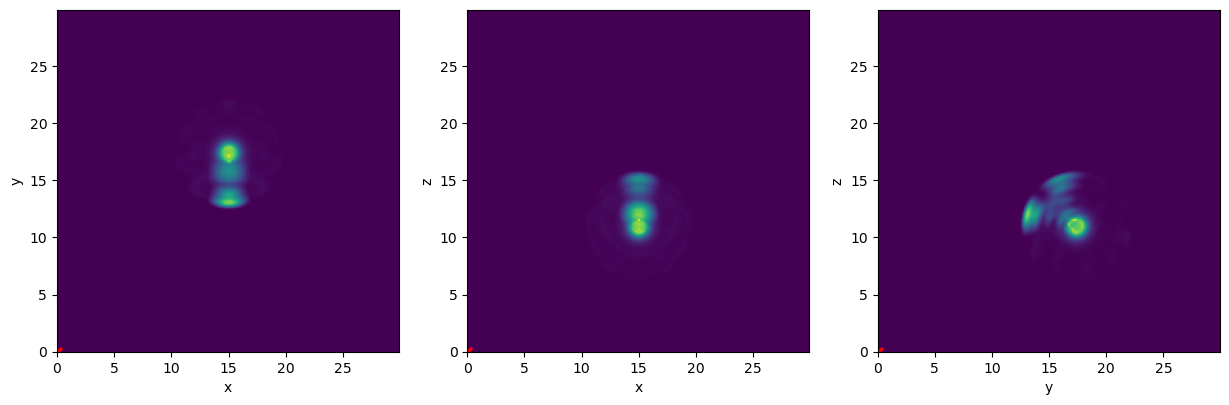

In [13]:
tst = np.zeros_like(rho)
tst[mask] = factors.T @ coeffs

fig, ax = plot_density_projections(project_density(tst), dens.atoms_positions * 0, dens.alat)

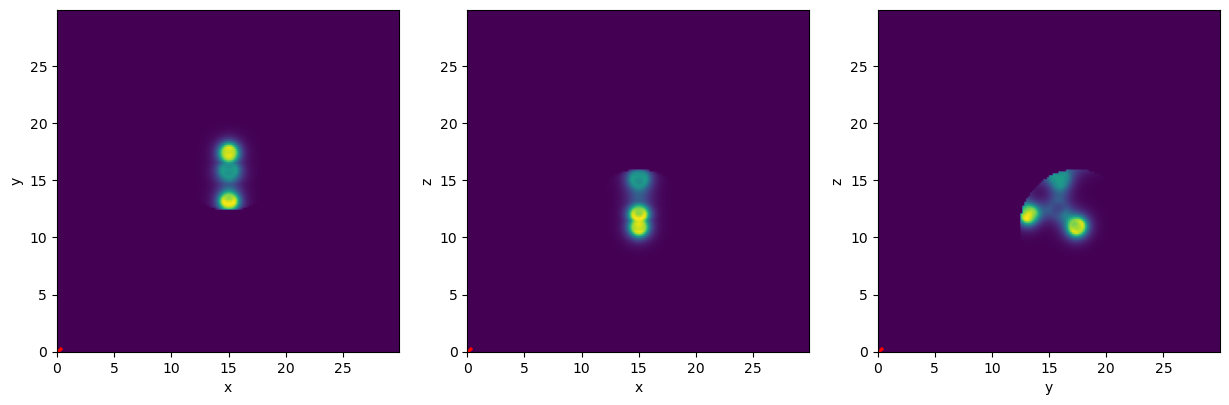

In [14]:
window_rho = np.zeros_like(rho)
window_rho[mask] = rho[mask]

fig, ax = plot_density_projections(project_density(window_rho), dens.atoms_positions * 0, dens.alat)

# Evaluation metrics
